## Herso 1 sailing alone
### Estimate Fuel use with vessel speed, h_0, current speed as input

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages



### create graph with navigation info

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4366,0],
    [0.8528,0], 
    [1.1443,0],
    [1.31495,0],
    [1.56274,0],
    [1.736384,0],
    [2.0710,0], 
    [2.20665,0],   
] 

# for each edge (between above coordinates) specify the depth (m)
depths = [7.5, 3, 3, 7.5, 7.5, 6.5, 10.6, 5.6]

current_speeds = [-0.8* 0.2777,-2.4* 0.2777,
                  -3.68* 0.2777,-1* 0.2777,
                  -1.5* 0.2777, -1.9* 0.2777,
                  -0.8* 0.2777,-0.7* 0.2777]  # [m/s]


V_g_profile_up = [16/3.6,11.85/3.6,10.57/3.6,16/3.6,16/3.6,16/3.6,16/3.6,16/3.6] 

V_g_profile_down = [4.44, 4.44, 4.44, 4.44,4.44, 4.44, 4.44, 4.44] # [m/s] for downstream

# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

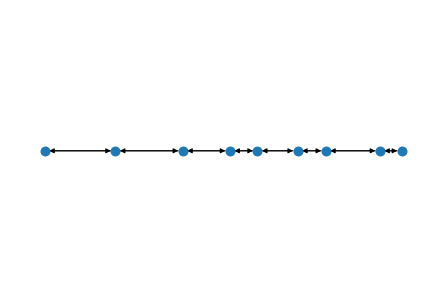

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {} m'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))
    print('Current speed for edge {} is {} m/s'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["CurrentSpeed"]))
    print('Vessel Speed To Ground for edge {} is {} m/s while sailing upstream'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile_upstream"]))
    print('Vessel Speed To Ground for edge {} is {} m/s while sailing downstream'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile_downstream"]))

General depth for edge ('Node 0', 'Node 1') is 7.5 m
Current speed for edge ('Node 0', 'Node 1') is -0.22216000000000002 m/s
Vessel Speed To Ground for edge ('Node 0', 'Node 1') is 4.444444444444445 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 0', 'Node 1') is 4.44 m/s while sailing downstream
General depth for edge ('Node 1', 'Node 0') is 7.5 m
Current speed for edge ('Node 1', 'Node 0') is -0.22216000000000002 m/s
Vessel Speed To Ground for edge ('Node 1', 'Node 0') is 4.444444444444445 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 1', 'Node 0') is 4.44 m/s while sailing downstream
General depth for edge ('Node 1', 'Node 2') is 3 m
Current speed for edge ('Node 1', 'Node 2') is -0.66648 m/s
Vessel Speed To Ground for edge ('Node 1', 'Node 2') is 3.2916666666666665 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 1', 'Node 2') is 4.44 m/s while sailing downstream
General depth for edge ('Node 2', 'Node 1') is 3 m
Current speed 

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [7]:
# Create a dict with all important settings

data_vessel_up = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":4.4,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 2020,
}             



In [8]:
# Create a dict with all important settings

data_vessel_down = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":4.44,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 2020, # although the construction year of Herso 1 is 1961, checking with the SFC used in the paper,it is similar as year of 2000
}             



### define sailing paths

In [9]:
path_upstream = nx.dijkstra_path(FG, nodes[0].name, nodes[7].name)
path_downstream = nx.dijkstra_path(FG, nodes[7].name, nodes[0].name)

### define simulation "Herso 1 sailing upstream and downstream"

In [10]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    # vessel.V_g_ave = V_g_ave
    # vessel.sailing_upstream = sailing_upstream
    # vessel.P_tot_given = P_tot_given
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

### run simulation to get energy consumption

### upstream energy consumption

In [11]:
vessel_upstream = run_simulation(path = path_upstream, **data_vessel_up)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_upstream = opentnsim.energy.EnergyCalculation(FG, vessel_upstream)
energycalculation_upstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_upstream = pd.DataFrame.from_dict(energycalculation_upstream.energy_use)
selected = ['edge_start','edge_stop','P_tot','P_installed','total_energy','total_diesel_consumption_C_year_ICE_mass','total_diesel_consumption_ICE_vol',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX',
            'total_LH2_consumption_PEMFC_mass','total_LH2_consumption_SOFC_mass','total_LH2_consumption_PEMFC_vol','total_LH2_consumption_SOFC_vol',
           'total_eLNG_consumption_PEMFC_mass','total_eLNG_consumption_SOFC_mass','total_eLNG_consumption_PEMFC_vol','total_eLNG_consumption_SOFC_vol',
            'total_eLNG_consumption_ICE_mass','total_eLNG_consumption_ICE_vol',
            'total_eMethanol_consumption_PEMFC_mass','total_eMethanol_consumption_SOFC_mass','total_eMethanol_consumption_PEMFC_vol','total_eMethanol_consumption_SOFC_vol',
            'total_eMethanol_consumption_ICE_mass','total_eMethanol_consumption_ICE_vol','total_eNH3_consumption_PEMFC_mass','total_eNH3_consumption_SOFC_mass',
            'total_eNH3_consumption_PEMFC_vol','total_eNH3_consumption_SOFC_vol','total_eNH3_consumption_ICE_mass','total_eNH3_consumption_ICE_vol',
            'total_Li_NMC_Battery_mass','total_Li_NMC_Battery_vol','total_Battery2000kWh_consumption_num']
df_upstream = df_upstream[selected]
df_upstream

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,P_tot,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_vol,total_emission_CO2,total_emission_PM10,total_emission_NOX,total_LH2_consumption_PEMFC_mass,total_LH2_consumption_SOFC_mass,total_LH2_consumption_PEMFC_vol,total_LH2_consumption_SOFC_vol,total_eLNG_consumption_PEMFC_mass,total_eLNG_consumption_SOFC_mass,total_eLNG_consumption_PEMFC_vol,total_eLNG_consumption_SOFC_vol,total_eLNG_consumption_ICE_mass,total_eLNG_consumption_ICE_vol,total_eMethanol_consumption_PEMFC_mass,total_eMethanol_consumption_SOFC_mass,total_eMethanol_consumption_PEMFC_vol,total_eMethanol_consumption_SOFC_vol,total_eMethanol_consumption_ICE_mass,total_eMethanol_consumption_ICE_vol,total_eNH3_consumption_PEMFC_mass,total_eNH3_consumption_SOFC_mass,total_eNH3_consumption_PEMFC_vol,total_eNH3_consumption_SOFC_vol,total_eNH3_consumption_ICE_mass,total_eNH3_consumption_ICE_vol,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num
0,POINT (0 0),POINT (0.4366 0),440.260534,780.0,1337.348871,260985.517747,0.363511,8.282856e+05,20.060233,3366.389721,99955.337723,94600.587488,1.302235,1.232472,250264.116253,236857.110025,0.590266,0.558645,271786.305529,0.641028,6.085032e+05,575904.856186,0.768177,0.727025,6.608332e+05,0.834239,6.513724e+05,6.164774e+05,1.060374,1.003568,7.073890e+05,1.151564,1.519715e+07,12.026519,0.835843
1,POINT (0.4366 0),POINT (0.8528 0),568.933227,780.0,2224.417149,424380.399165,0.591095,1.346849e+06,32.836391,5238.126166,176647.074244,161802.782290,2.301388,2.107994,442281.772354,405115.236862,1.043154,0.955494,441943.222841,1.042356,1.075383e+06,985015.109738,1.357569,1.243488,1.074560e+06,1.356530,1.151144e+06,1.054410e+06,1.873956,1.716481,1.150263e+06,1.872521,2.527747e+07,20.003751,1.390261
2,POINT (0.8528 0),POINT (1.1443 0),568.815272,780.0,1746.248439,333164.097124,0.464045,1.057358e+06,25.778554,4112.309860,138674.383852,127021.074284,1.806673,1.654852,347207.291899,318030.208547,0.818914,0.750098,346951.968346,0.818312,8.442152e+05,773272.719135,1.065741,0.976183,8.435944e+05,1.064958,9.036902e+05,8.277499e+05,1.471124,1.347500,9.030257e+05,1.470042,1.984373e+07,15.703673,1.091405
3,POINT (1.1443 0),POINT (1.31495 0),459.559130,780.0,545.630853,105967.634581,0.147596,3.363078e+05,8.184463,1354.028327,40781.218214,38596.510095,0.531305,0.502842,102106.358386,96636.374901,0.240825,0.227924,110353.065400,0.260276,2.482659e+05,234965.957254,0.313412,0.296622,2.683173e+05,0.338725,2.657563e+05,2.515193e+05,0.432626,0.409450,2.872203e+05,0.467568,6.200351e+06,4.906752,0.341019
4,POINT (1.31495 0),POINT (1.56274 0),520.512505,780.0,897.358895,172203.171891,0.239852,5.465185e+05,13.325780,2163.792868,68522.242226,64099.285111,0.892719,0.835096,171563.207979,160489.187533,0.404645,0.378526,179329.735583,0.422962,4.171464e+05,390220.510821,0.526608,0.492616,4.360303e+05,0.550447,4.465344e+05,4.177116e+05,0.726916,0.679996,4.667486e+05,0.759823,1.019726e+07,8.069774,0.560849
5,POINT (1.56274 0),POINT (1.736384 0),652.888760,780.0,788.769668,149866.236985,0.208740,4.756281e+05,11.507273,1806.808434,62638.365387,57374.637203,0.816063,0.747486,156831.396044,143652.287133,0.369898,0.338815,156068.395002,0.368099,3.813268e+05,349282.526302,0.481389,0.440936,3.794716e+05,0.479047,4.081913e+05,3.738895e+05,0.664497,0.608657,4.062054e+05,0.661265,8.963292e+06,7.093252,0.492981
6,POINT (1.736384 0),POINT (2.071 0),406.608138,780.0,946.616344,186285.468635,0.259466,5.912113e+05,14.280770,2441.644285,68937.958115,66235.790689,0.898135,0.862931,172604.060543,165838.483454,0.407099,0.391142,193994.822897,0.457551,4.196771e+05,403227.025584,0.529802,0.509036,4.716876e+05,0.595461,4.492434e+05,4.316344e+05,0.731327,0.702661,5.049180e+05,0.821960,1.075700e+07,8.512737,0.591635


#### upstream_total_diesel_use [kg] of main engine

In [12]:
upstream_total_diesel_use_ME = (df_upstream['total_diesel_consumption_C_year_ICE_mass']/1000).sum() #kg
upstream_total_diesel_use_ME

1632.8525261276757

### downstream energy consumption

In [13]:
vessel_downstream = run_simulation(path = path_downstream, **data_vessel_down)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_downstream = opentnsim.energy.EnergyCalculation(FG, vessel_downstream)
energycalculation_downstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_downstream = pd.DataFrame.from_dict(energycalculation_downstream.energy_use)
selected = ['edge_start','edge_stop','P_tot','P_installed','total_energy','total_diesel_consumption_C_year_ICE_mass','total_diesel_consumption_ICE_vol',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX',
            'total_LH2_consumption_PEMFC_mass','total_LH2_consumption_SOFC_mass','total_LH2_consumption_PEMFC_vol','total_LH2_consumption_SOFC_vol',
           'total_eLNG_consumption_PEMFC_mass','total_eLNG_consumption_SOFC_mass','total_eLNG_consumption_PEMFC_vol','total_eLNG_consumption_SOFC_vol',
            'total_eLNG_consumption_ICE_mass','total_eLNG_consumption_ICE_vol',
            'total_eMethanol_consumption_PEMFC_mass','total_eMethanol_consumption_SOFC_mass','total_eMethanol_consumption_PEMFC_vol','total_eMethanol_consumption_SOFC_vol',
            'total_eMethanol_consumption_ICE_mass','total_eMethanol_consumption_ICE_vol','total_eNH3_consumption_PEMFC_mass','total_eNH3_consumption_SOFC_mass',
            'total_eNH3_consumption_PEMFC_vol','total_eNH3_consumption_SOFC_vol','total_eNH3_consumption_ICE_mass','total_eNH3_consumption_ICE_vol',
            'total_Li_NMC_Battery_mass','total_Li_NMC_Battery_vol','total_Battery2000kWh_consumption_num']
df_downstream = df_downstream[selected]
df_downstream

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,P_tot,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_vol,total_emission_CO2,total_emission_PM10,total_emission_NOX,total_LH2_consumption_PEMFC_mass,total_LH2_consumption_SOFC_mass,total_LH2_consumption_PEMFC_vol,total_LH2_consumption_SOFC_vol,total_eLNG_consumption_PEMFC_mass,total_eLNG_consumption_SOFC_mass,total_eLNG_consumption_PEMFC_vol,total_eLNG_consumption_SOFC_vol,total_eLNG_consumption_ICE_mass,total_eLNG_consumption_ICE_vol,total_eMethanol_consumption_PEMFC_mass,total_eMethanol_consumption_SOFC_mass,total_eMethanol_consumption_PEMFC_vol,total_eMethanol_consumption_SOFC_vol,total_eMethanol_consumption_ICE_mass,total_eMethanol_consumption_ICE_vol,total_eNH3_consumption_PEMFC_mass,total_eNH3_consumption_SOFC_mass,total_eNH3_consumption_PEMFC_vol,total_eNH3_consumption_SOFC_vol,total_eNH3_consumption_ICE_mass,total_eNH3_consumption_ICE_vol,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num
0,POINT (2.071 0),POINT (1.736384 0),290.999602,780.0,678.148551,139255.223008,0.193960,441952.102494,10.586944,1950.251775,47448.274682,46090.619925,0.618164,0.600476,118799.063677,115399.822820,0.280196,0.272179,145018.248191,0.342036,288853.299252,280588.234644,0.364650,0.354216,352603.784450,0.445129,309203.042448,300355.703230,0.503354,0.488951,377444.755566,0.614445,7.706234e+06,6.098458,0.423843
1,POINT (1.736384 0),POINT (1.56274 0),253.236321,780.0,306.246770,64013.442914,0.089161,203158.453038,4.893224,926.462928,21049.994849,20436.888203,0.274243,0.266255,52704.122441,51169.050913,0.124307,0.120686,66662.615244,0.157229,128147.135002,124414.694177,0.161774,0.157062,162086.431946,0.204619,137175.113202,133179.721555,0.223308,0.216804,173505.436936,0.282451,3.480077e+06,2.754018,0.191404
2,POINT (1.56274 0),POINT (1.31495 0),256.152145,780.0,442.046048,92273.393073,0.128522,292846.610647,7.048158,1331.336310,30384.212830,29499.235758,0.395851,0.384321,76074.758440,73858.988777,0.179428,0.174202,96092.092842,0.226640,184971.533318,179584.012930,0.233509,0.226708,233642.565778,0.294951,198002.795939,192235.724213,0.322330,0.312942,250102.707398,0.407144,5.023251e+06,3.975234,0.276279
3,POINT (1.31495 0),POINT (1.1443 0),287.514304,780.0,341.705122,70283.886438,0.097894,223058.860644,5.343705,986.539465,23826.697139,23142.602802,0.310418,0.301506,59656.316897,57943.509271,0.140704,0.136664,73192.558722,0.172630,145051.008178,140886.411938,0.183113,0.177856,177963.625412,0.224662,155269.865897,150811.873444,0.252765,0.245508,190501.180236,0.310118,3.883013e+06,3.072888,0.213566
4,POINT (1.1443 0),POINT (0.8528 0),239.350643,780.0,485.913425,102225.812927,0.142384,324432.448394,7.841798,1501.134639,33399.454634,32426.654985,0.435134,0.422460,83624.198445,81188.542180,0.197234,0.191489,106456.389860,0.251085,203327.575744,197405.413343,0.256682,0.249206,258842.776076,0.326764,217652.023350,211312.644029,0.354317,0.343997,277078.274978,0.451058,5.521743e+06,4.369725,0.303696
5,POINT (0.8528 0),POINT (0.4366 0),408.469139,780.0,1183.987359,232890.575760,0.324380,739121.143069,17.853304,3049.836743,86413.171876,82920.308048,1.125805,1.080300,216357.791238,207612.500601,0.510296,0.489669,242528.664903,0.572022,526061.905568,504798.219012,0.664103,0.637260,589694.925632,0.744434,563123.018289,540361.302935,0.916712,0.879658,631238.990843,1.027598,1.345440e+07,10.647368,0.739992
6,POINT (0.4366 0),POINT (0 0),300.821034,780.0,914.697878,186954.397299,0.260398,593334.218798,14.210739,2601.507472,64613.891488,62782.664505,0.841801,0.817943,161777.638087,157192.686318,0.381565,0.370751,194691.434923,0.459194,393353.306500,382205.251925,0.496571,0.482498,473381.368278,0.597599,421065.085432,409131.649321,0.685455,0.666028,506731.131992,0.824911,1.039429e+07,8.225700,0.571686


#### downstream_total_diesel_use [kg] of main engine

In [14]:
downstream_total_diesel_use_ME = (df_downstream['total_diesel_consumption_C_year_ICE_mass']/1000).sum() #kg
downstream_total_diesel_use_ME

887.8967314194641

#### roundtrip_total_diesel_use [kg] of main engine

In [15]:
roundtrip_total_diesel_use_ME = upstream_total_diesel_use_ME + downstream_total_diesel_use_ME
roundtrip_total_diesel_use_ME

2520.7492575471397